<a href="https://colab.research.google.com/github/SantiagoJusteValverde/Grupo35_Practica2/blob/main/Grupo35_Practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**OBJETIVO DE PREDICCIÓN**

*Crear un modelo que prediga si es probable que los empleados
abandonen la empresa, usando un conjunto de datos recopilados por el departamento de
recursos humanos.*

In [63]:
%matplotlib inline
#######
# Importamos todas las dependencias
import numpy as np
import matplotlib.pyplot as plt


from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn import metrics

np.random.seed(35)

In [17]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
#path = "/content/drive/MyDrive/Copia Seguridad/D:/santi/Escritorio/Universidad/Quinto/Segundo cuatrimestre/Aprendizaje Automático/Grupo/Aprendizaje Automático/Práctica 2/"
path="C:/Users/mferh/DataspellProjects/Grupo35_Practica2/"

inputFilename = "attrition_available_35.pkl"

In [32]:
import pickle
import pandas as pd

with open(path + inputFilename, 'rb') as f:
    df = pickle.load(f)


y_data_set = df['Attrition']
X_data_set = df.drop('Attrition', axis=1)

#print(X.iloc[0]) #imprimimos la primera columna del conjunto de entrada


In [65]:
"""Mostramos  información acerca de nuestro conjunto de datos"""

# Descripción general del conjunto de datos
print('Información general del conjunto de datos:')
print(X_data_set.info())

# Estadísticas descriptivas de las variables numéricas
print('Estadísticas descriptivas de las variables numéricas:')
print(X_data_set.describe())





Información general del conjunto de datos:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      3671 non-null   float64
 1   absences                 3657 non-null   float64
 2   JobInvolvement           3618 non-null   float64
 3   PerformanceRating        3457 non-null   float64
 4   EnvironmentSatisfaction  3630 non-null   float64
 5   JobSatisfaction          3589 non-null   float64
 6   WorkLifeBalance          3514 non-null   float64
 7   Age                      3660 non-null   float64
 8   BusinessTravel           4410 non-null   int64  
 9   Department               4410 non-null   int64  
 10  DistanceFromHome         3502 non-null   float64
 11  Education                4410 non-null   int64  
 12  EducationField           4410 non-null   int64  
 13  EmployeeCount            3603 non-n

In [66]:
# Calculamos el número de valores nulos por variable

null_counts = X_data_set.isnull().sum()
null_pct = null_counts / len(X_data_set) * 100
null_df = pd.DataFrame({'Variable': null_counts.index, 'Total Nulos': null_counts.values, '% Nulos': null_pct.values})

# Imprimir el DataFrame con los resultados
print("\n-Valores nulos para cada variable de nuestro conjunto de datos de entrada \n")
display(null_df)



-Valores nulos para cada variable de nuestro conjunto de datos de entrada 



,Variable,Total Nulos,% Nulos
0,hrs,739,16.757370
1,absences,753,17.074830
2,JobInvolvement,792,17.959184
3,PerformanceRating,953,21.609977
4,EnvironmentSatisfaction,780,17.687075
5,JobSatisfaction,821,18.616780
6,WorkLifeBalance,896,20.317460
7,Age,750,17.006803
8,BusinessTravel,0,0.000000
9,Department,0,0.000000


Hallamos el tipo de las distintas variables.

Variables categóricas = [BusinessTravel, Departament, Gender, EducationField, Over18, MaritalStatus, JobRole]



In [79]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# Obtener una lista de todas las variables en el conjunto de datos
variables_entrada = list(X_data_set.columns)


# Crear una lista de variables categóricas
variables_categoricas = ['BusinessTravel', 'Department', 'Gender', 'EducationField', 'Over18', 'MaritalStatus', 'JobRole']
variables_numericas = []

# Iterar sobre cada variable y comprobar si es de tipo object
for var in variables_entrada:
    if var not in variables_categoricas:
        variables_numericas.append(var)



# Imprimir el número de variables categóricas
print("-El número total de variables categóricas en el conjunto de datos es: ", len(variables_categoricas))
print("-El número total de variables numéricas en el conjunto de datos es: ", len(variables_numericas))




-El número total de variables categóricas en el conjunto de datos es:  7
-El número total de variables numéricas en el conjunto de datos es:  23


Análisis de las variables numéricas

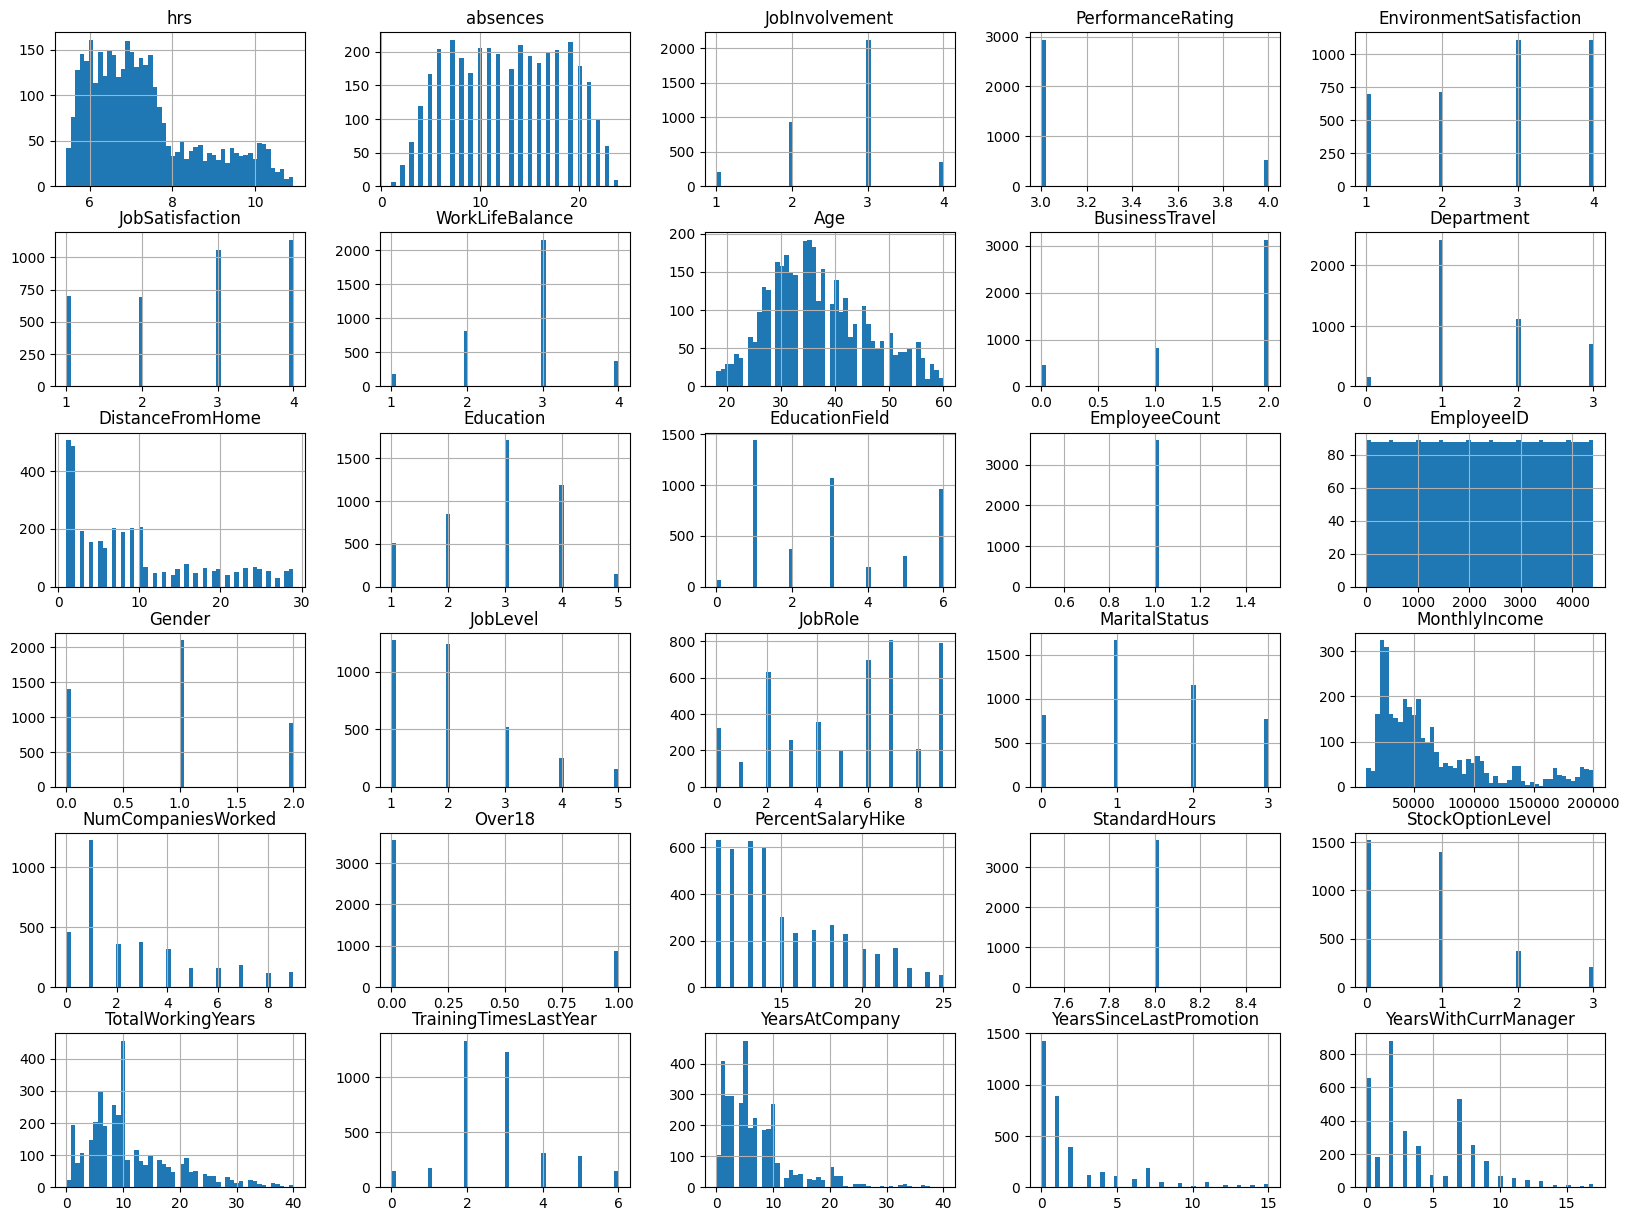

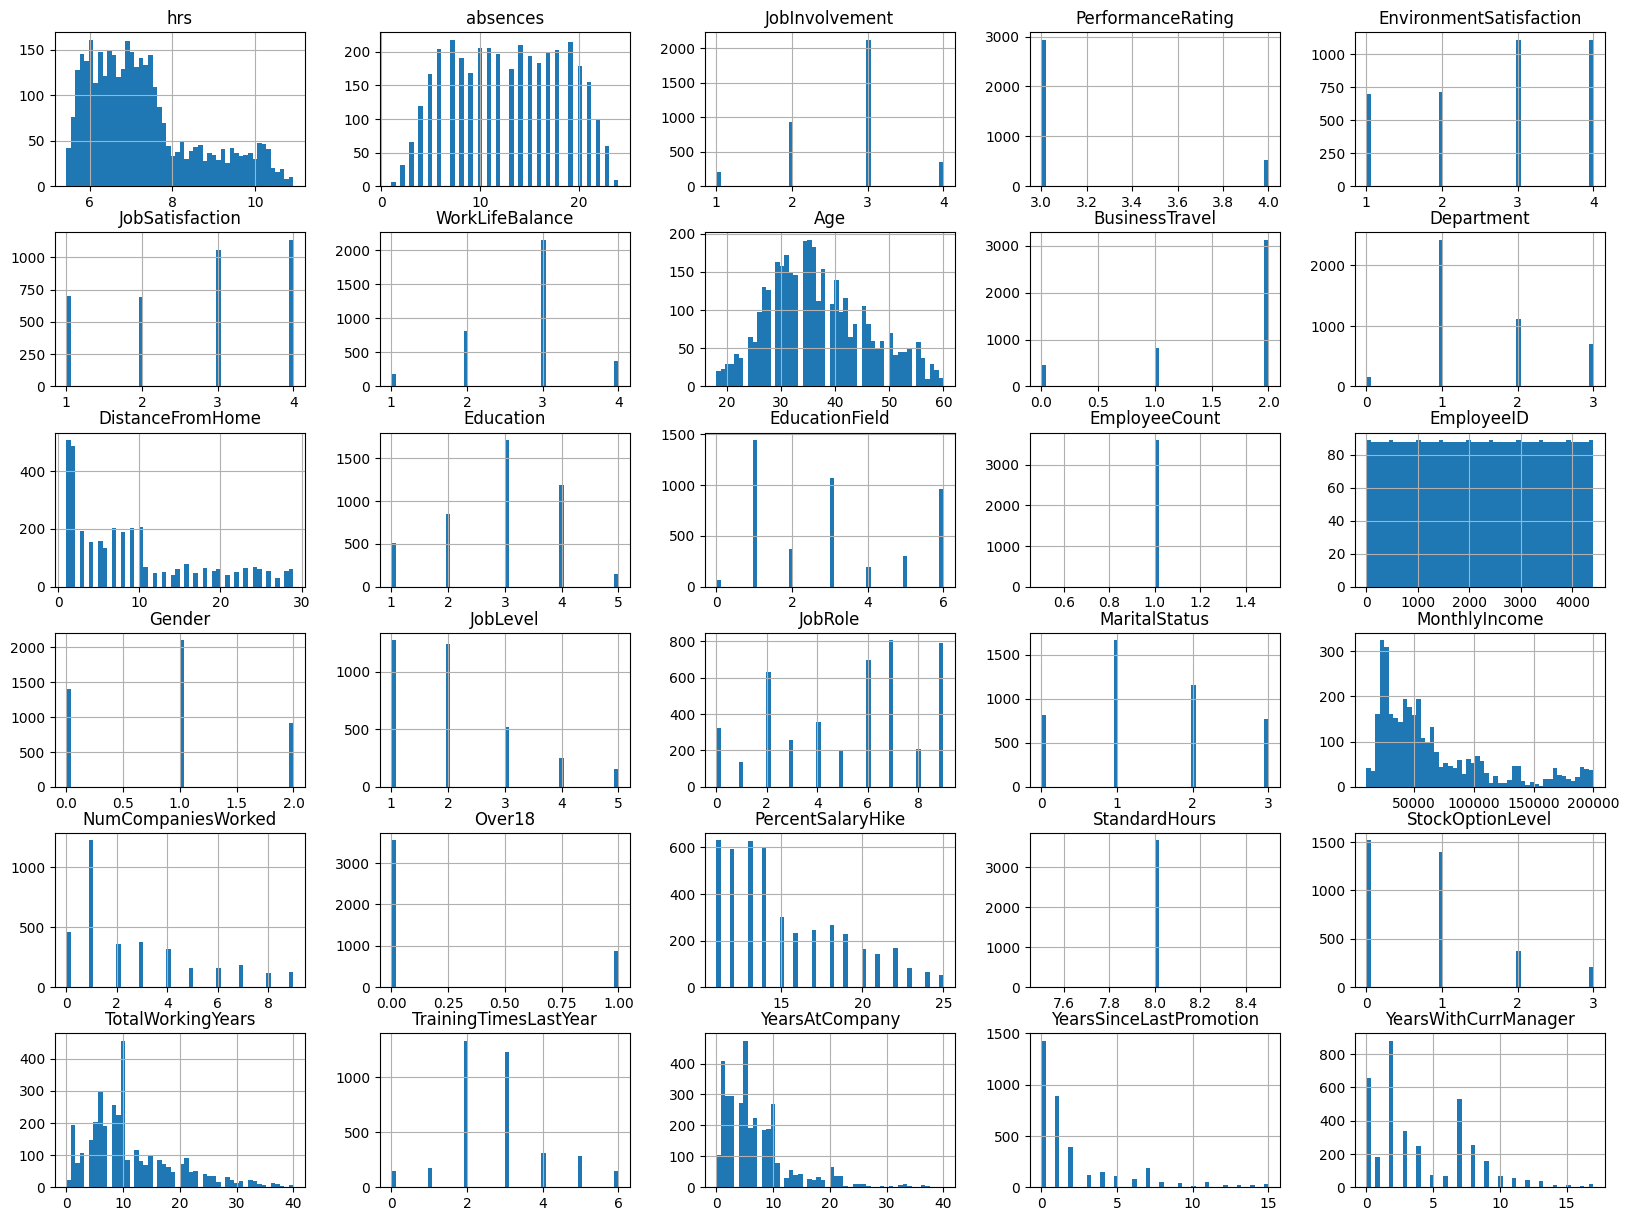

In [81]:
"""HISTOGRAMAS DE NUESTRAS VARIABLES"""
X_data_set.hist(bins=50, figsize=(20,15))
plt.show()



In [82]:
import pandas as pd

# Crear un diccionario vacío para almacenar los resultados
resultados_atipicos = {}

# Recorrer todas las variables numéricas del dataframe
for variable in variables_numericas:
    q1 = X_data_set[variable].quantile(0.25)
    q3 = X_data_set[variable].quantile(0.75)
    iqr = q3 - q1
    lim_inf = q1 - 1.5 * iqr
    lim_sup = q3 + 1.5 * iqr
    outliers = X_data_set[(X_data_set[variable] < lim_inf) | (X_data_set[variable] > lim_sup)][variable]
    num_outliers = len(outliers)
    resultados_atipicos[variable] = {"Num_outliers": num_outliers}

# Crear un dataframe final que contenga todos los resultados
df_resultados_at = pd.DataFrame(resultados_atipicos).T
df_resultados_at.index.name = 'Variable'

display(df_resultados_at)


,Num_outliers
Variable,
hrs,107
absences,0
JobInvolvement,0
PerformanceRating,519
EnvironmentSatisfaction,0
JobSatisfaction,0
WorkLifeBalance,0
Age,0
DistanceFromHome,0


Análisis para variables categóricas

In [83]:
import pandas as pd

# Crear un diccionario vacío para almacenar los resultados
resultados = {}

# Recorrer todas las variables categóricas del dataframe
for variable in variables_categoricas:
    # Calcular la frecuencia para cada valor de la variable
    frecuencias = df[variable].value_counts()
    # Crear un nuevo dataframe con la frecuencia para cada valor de la variable
    df_frecuencias = pd.DataFrame({'Valor': frecuencias.index, 'Frecuencia': frecuencias.values})
    # Agregar el dataframe de frecuencias al diccionario de resultados
    resultados[variable] = df_frecuencias

# Crear un dataframe final que contenga todos los resultados
df_resultados = pd.DataFrame(columns=['Variable', 'Valor', 'Frecuencia'])
for variable, df_frecuencias in resultados.items():
    df_frecuencias['Variable'] = variable
    df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
df_resultados = df_resultados[['Variable', 'Valor', 'Frecuencia']]

display(df_resultados)

C:\Users\mferh\AppData\Local\Temp\ipykernel_1984\3377140788.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
C:\Users\mferh\AppData\Local\Temp\ipykernel_1984\3377140788.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
C:\Users\mferh\AppData\Local\Temp\ipykernel_1984\3377140788.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_resultados = df_resultados.append(df_frecuencias, ignore_index=True)
C:\Users\mferh\AppData\Local\Temp\ipykernel_1984\3377140788.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

,Variable,Valor,Frecuencia
0,BusinessTravel,Travel_Rarely,3129
1,BusinessTravel,Travel_Frequently,831
2,BusinessTravel,Non-Travel,450
3,Department,Research & Development,2424
4,Department,Sales,1119
5,Department,Human Resources,159
6,Gender,Male,2101
7,Gender,Female,1401
8,EducationField,Life Sciences,1444
9,EducationField,Medical,1066


In [84]:
import pandas as pd

resultados_moda = {}
for variable in variables_categoricas:

    moda = df[variable].mode().values[0]
    df_moda = pd.DataFrame({'Variable': variable, 'Moda': moda}, index=[0])
    resultados_moda[variable] = df_moda

df_modas = pd.concat(resultados_moda.values(), ignore_index=True)
display(df_modas)


,Variable,Moda
0,BusinessTravel,Travel_Rarely
1,Department,Research & Development
2,Gender,Male
3,EducationField,Life Sciences
4,Over18,Y
5,MaritalStatus,Married
6,JobRole,Sales Executive


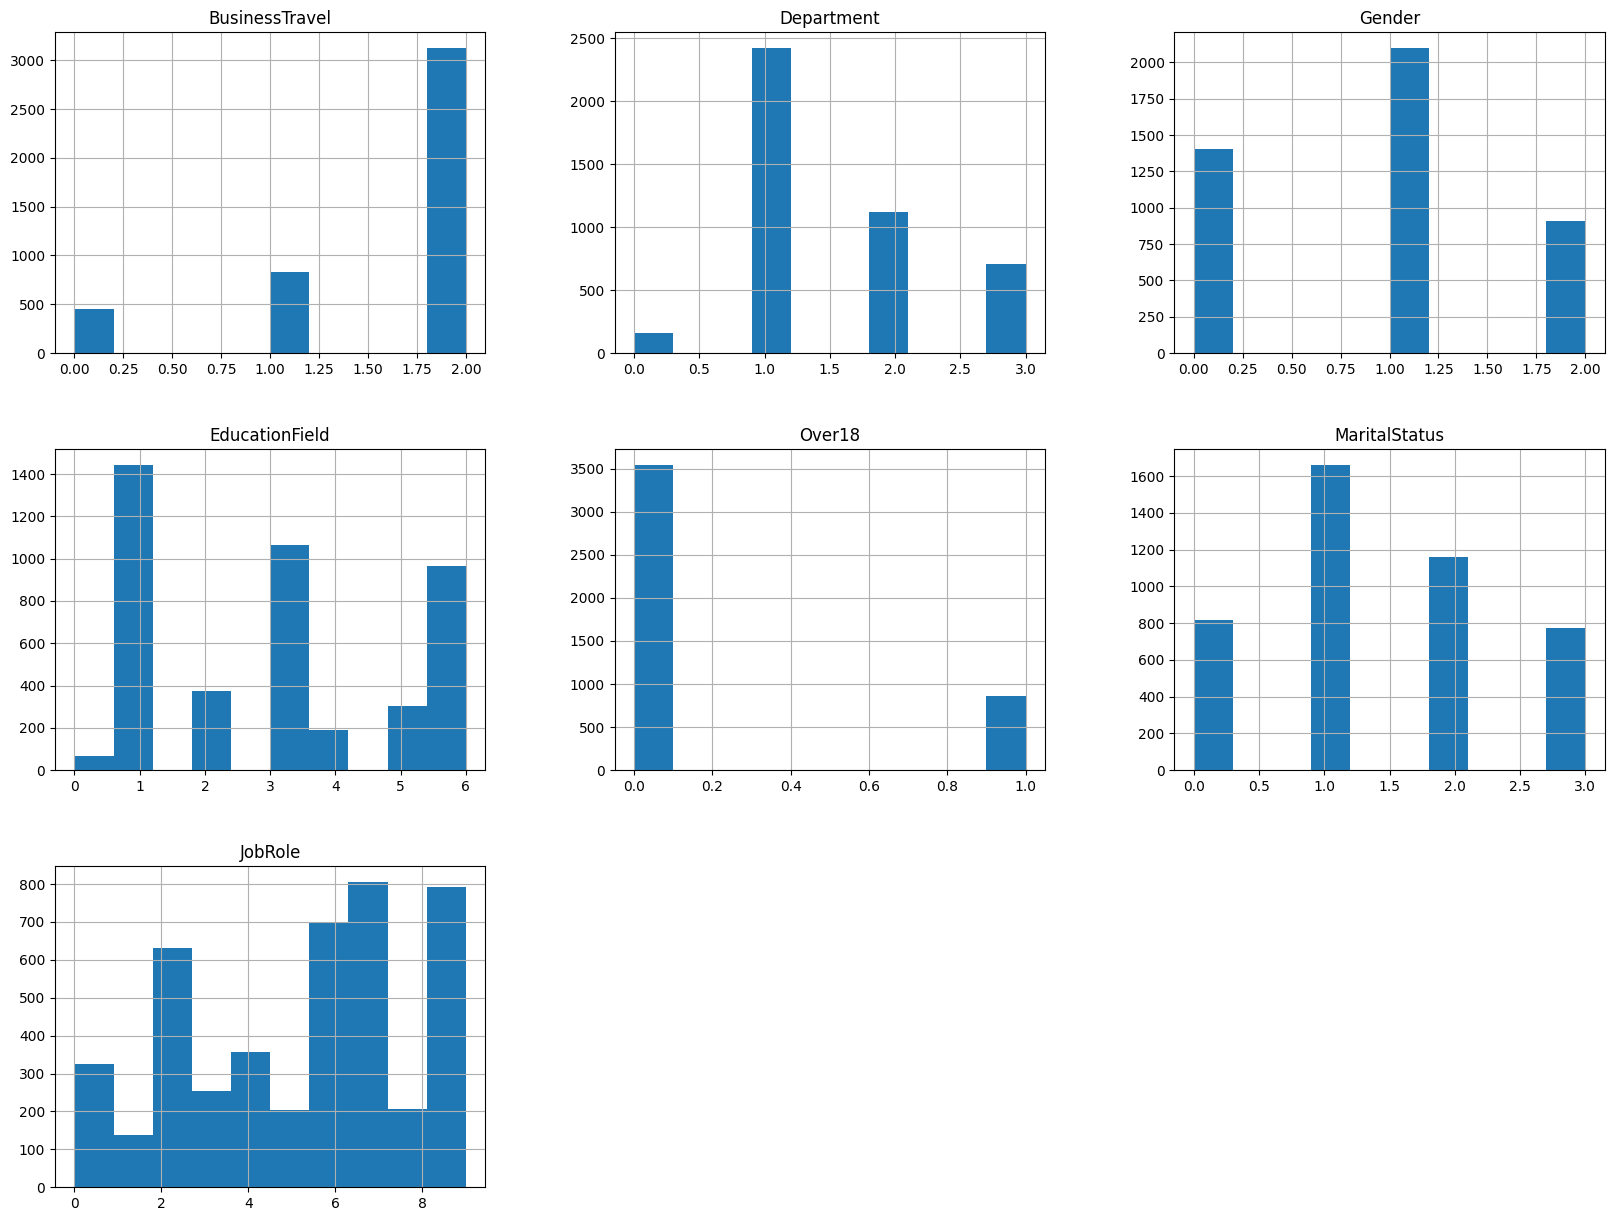

In [85]:
# Gráfico de barras de las variables categóricas

le = LabelEncoder()
for col in variables_categoricas:
    X_data_set[col] = le.fit_transform(X[col])
X_data_set[variables_categoricas].hist(figsize=(20,15))
plt.show()



In [86]:
# Matriz de correlación
corr_matrix = X_data_set.corr()
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)


C:\Users\mferh\AppData\Local\Temp\ipykernel_1984\1239892901.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)
C:\Users\mferh\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\io\formats\style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\mferh\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\io\formats\style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
hrs,1.00,-0.37,-0.04,0.06,0.06,0.02,-0.01,0.00,0.03,-0.02,0.01,0.00,-0.00,nan,-0.00,-0.02,0.01,0.03,0.00,-0.01,-0.01,0.00,0.02,nan,-0.01,-0.01,-0.00,-0.02,-0.01,-0.02
absences,-0.37,1.00,0.03,0.01,-0.02,0.01,-0.00,0.02,-0.01,0.01,-0.00,0.02,-0.02,nan,-0.01,-0.01,0.03,-0.01,0.01,-0.01,0.02,-0.02,0.01,nan,-0.02,-0.00,-0.01,-0.01,-0.01,-0.02
JobInvolvement,-0.04,0.03,1.00,0.00,0.02,0.01,0.00,0.00,-0.01,-0.02,-0.00,-0.03,0.02,nan,0.01,0.01,-0.00,-0.04,-0.03,0.04,0.04,0.01,0.00,nan,0.02,0.02,0.00,0.02,0.04,-0.00
PerformanceRating,0.06,0.01,0.00,1.00,0.01,0.05,-0.02,-0.02,-0.02,0.02,0.03,-0.03,0.01,nan,0.00,0.02,-0.02,0.01,0.00,0.02,0.03,-0.01,0.77,nan,-0.02,-0.00,0.00,-0.00,-0.01,-0.03
EnvironmentSatisfaction,0.06,-0.02,0.02,0.01,1.00,-0.01,0.02,0.01,0.00,0.00,0.01,-0.05,-0.02,nan,0.01,-0.02,-0.03,0.00,-0.01,-0.00,0.03,-0.02,-0.01,nan,-0.01,0.01,0.02,0.00,0.02,0.00
JobSatisfaction,0.02,0.01,0.01,0.05,-0.01,1.00,-0.05,-0.02,-0.03,0.01,-0.01,-0.01,0.01,nan,-0.02,-0.00,-0.01,0.00,0.00,0.01,-0.04,0.01,0.05,nan,0.03,-0.04,-0.04,0.00,-0.03,-0.03
WorkLifeBalance,-0.01,-0.00,0.00,-0.02,0.02,-0.05,1.00,-0.02,-0.01,0.02,0.01,-0.01,-0.02,nan,-0.01,-0.00,-0.00,0.00,0.01,0.01,-0.00,-0.01,-0.04,nan,-0.02,-0.01,-0.03,0.01,0.01,-0.00
Age,0.00,0.02,0.00,-0.02,0.01,-0.02,-0.02,1.00,0.03,0.02,0.03,-0.03,0.03,nan,0.01,-0.02,0.02,0.01,-0.05,-0.04,0.31,0.01,-0.03,nan,-0.03,0.69,-0.01,0.30,0.22,0.20
BusinessTravel,0.03,-0.01,-0.01,-0.02,0.00,-0.03,-0.01,0.03,1.00,-0.01,0.02,0.00,0.00,nan,-0.00,-0.04,0.05,-0.02,0.01,-0.04,0.01,-0.04,-0.03,nan,0.01,0.04,-0.04,-0.01,-0.03,-0.02
Department,-0.02,0.01,-0.02,0.02,0.00,0.01,0.02,0.02,-0.01,1.00,0.00,0.00,0.04,nan,-0.01,-0.01,0.01,0.01,-0.01,-0.02,-0.02,0.01,0.02,nan,-0.00,0.01,0.01,0.02,0.02,0.01
